In [106]:
from w2v_lda import *

In [44]:
%%time
wd_data=pd.read_parquet('data\patent_cut_doc.parquet')
co_data=pd.read_parquet('data\patent_co_ids.parquet')
patent_co=pd.read_csv('data\融资公司专利2024.csv',usecols=['序号','标题 (中文)', '摘要 (中文)','申请号','申请日','申请人','公开（公告）号','Co','table'])

df_co=pd.read_excel('data\公司融资变量2_20240301.xlsx',usecols=['公司序号','公司简称','工商全称','行业'])
co=df_co.loc[df_co.行业=='先进制造','工商全称'].unique()

Stopwords=set(read2list('data\\专利停用词表2024.txt'))
bd_word=pd.read_excel('data\\百度输入法词库1.xlsx',index_col=0)

CPU times: total: 1min 31s
Wall time: 1min 25s


In [13]:
wd_data.columns,co_data.columns,patent_co.columns

(Index(['序号', '词语'], dtype='object'),
 Index(['Co', '序号'], dtype='object'),
 Index(['序号', '标题 (中文)', '摘要 (中文)', '申请人', '申请日', '申请号', '公开（公告）号', 'table'], dtype='object'))

In [190]:
patent_co.shape,wd_data.shape

((1897517, 9), (1889962, 2))

In [253]:
patent_co['table'].value_counts()

table
patent202404                    846384
patent202210                    706371
patent_incopat_202101_202211    286413
patent_incopat_202212_202312     43636
patent202309                     14713
Name: count, dtype: int64

In [45]:
wd_data['词语']=wd_data['词语'].dropna().apply(lambda x: x.tolist())

In [347]:
patent_co_1=patent_co[patent_co['Co'].isin(co)].copy()
patent_co_1.申请日.min()

'1994-08-31'

In [349]:
patent_co_1['申请年']=pd.to_datetime(patent_co_1.申请日).dt.year
co_data_1=co_data[co_data.Co.isin(co)].copy()#patent_co_1['申请人'].str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).rename('Co')

In [204]:
co_data_1.shape,patent_co_1.Co.nunique()

((7370, 2), 7370)

In [350]:
(patent_co_1['申请年']==1994).sum()

4

  CBOW对小型数据库比较合适，而Skip-Gram在大型语料中表现更好。 当语料较少时使用CBOW方法比较好，当语料较多时采用skip-gram表示比较好。  

  主题模型是一种基于概率图模型的生成式模型，其似然函数可以写成若干条件概率连乘的形式，其中包括需要推测的隐含变量（即主题）；  
  而词嵌入模型一般表达为神经网络的形式，似然函数定义在网络的输出之上，需要通过学习网络的权重以得到单词的稠密向量表示。

  如果文档数量较少，Word2Vec（w2v）模型的相似度结果可能会变得不那么准确。    
词汇覆盖率低：文档少意味着训练数据少，许多词可能不会出现在训练集中，导致模型无法有效学习这些词的语义。  
语境信息不足：Word2Vec依赖于大量的上下文来学习词语之间的关系。文档少意味着模型能学习到的上下文信息有限，影响词向量的质量。  
过拟合风险高：在小数据集上训练的模型可能会过拟合，即过于贴合训练数据，而在新的数据上表现不佳。这样，模型可能会高估一些词之间的相似度，因为它们在训练集中偶然频繁地一起出现。   

文档数量和质量：
最小数量：一般来说，至少需要数千篇文档（或几十万到几百万的词）才能训练出一个有用的Word2Vec模型。如果文档太少，模型可能无法捕捉到足够的上下文信息来生成有意义的词向量。  
理想数量：为了获得更高质量的词向量，通常建议使用数百万篇文档（或数十亿个词）。

文档长度：
短文档：如果文档较短，例如社交媒体帖子或新闻摘要，那么需要更多的文档来覆盖足够的词汇和上下文。  
长文档：如果文档较长，例如书籍或长篇论文，那么较少的文档也能提供足够的上下文信息。

领域专注：
如果是在一个非常专门的领域（例如医学或法律），需要特定领域的大量文档来确保模型能够捕捉到该领域特有的词汇和语义。

一般应用：对于一般应用，如新闻分类或产品推荐，需要数百万到数千万的词。  
特定领域应用：对于特定领域的应用，建议收集尽可能多的领域相关文档，以确保模型能够准确地捕捉该领域的特定词汇和语义。

如果无法获得足够多的文档，可以考虑使用预训练的词向量（如Google的Word2Vec或GloVe）作为基础

In [49]:
len(patent_co_1),len(patent_co)#可先分个1000万专利上训练

(944627, 1897517)

In [35]:
patent_co_1['申请年'].value_counts()

申请年
2021    134978
2022    109812
2020    103997
2019     90856
2018     81509
2023     77849
2017     70823
2016     63691
2015     45376
2014     30713
2012     24362
2013     23642
2011     19393
2010     16845
2009     14284
2008     10735
2007     10550
2006      5599
2005      3185
2004      2006
2024      1537
2003      1459
2002       642
2001       426
2000       173
1999       132
1997        19
1998        14
1996         9
1995         7
1994         4
Name: count, dtype: int64

In [36]:
(patent_co_1['申请年']<=2000).sum()

358

w2v：尽可能多的训练，用已分词的  ：processed_doc,wd_data  
lda：用当前先进制造，每年训练主体标签和主题词不会统一  ：corpus,document_topics,documents_vec,df_lda_w2v  
结合：每年分开筛选，表示  :group_ids  


In [277]:
import w2v_lda
import importlib
importlib.reload(w2v_lda)
from w2v_lda import *

In [126]:
model=W2vLda(wd_data['词语'].dropna(),
             suffix='先进制造',
             stop_words=Stopwords
            )

In [ ]:
%%time
model.lda=1#不跑lda,先w2v
r1=model.on_corpus(vector_size=250,sg=1,window=5,count_fifter=5,min_count=3,no_below=3,num_topics=50,chunksize=3000,keep_n=800000,passes=3)
print(r1)
model.lda=None#重建corpus
filter_ids=patent_co.loc[patent_co['Co'].isin(co),'序号']
model.on_init(wd_data.loc[wd_data.序号.isin(filter_ids),'词语'].dropna(),suffix='先进制造')
r2=model.on_corpus()
print(r2)
model.save()

{'vector_size': 250, 'sg': 1, 'window': 5, 'len_below': 2, 'no_below': 3, 'min_count': 3, 'count_fifter': 5, 'num_topics': 50, 'top_n_words': 20, 'weight_threshold_topics': 0.03, 'chunksize': 3000, 'keep_n': 800000, 'passes': 3, 'top_n_topics': 3}


In [335]:
importlib.reload(w2v_lda)
from w2v_lda import *

model=W2vLda(wd_data['词语'].dropna(),
             suffix='188_27_sg',
             stop_words=Stopwords
            )
model.load(dictionary=False,lda=False)

In [336]:
model.on_init(wd_data.loc[wd_data.序号.isin(filter_ids),'词语'].dropna(),suffix='先进制造')
len(model.stop_words),len(model.sentences)

(6956, 1196876)

In [337]:
%%time
r2=model.on_corpus(count_fifter=5,min_count=3,no_below=3,num_topics=50,chunksize=3000,keep_n=800000,passes=3,no_above=0.99)#vector_size=250,sg=1,window=5,
print(r2)
model.save()

{'vector_size': 250, 'sg': 0, 'window': 5, 'len_below': 2, 'no_below': 3, 'min_count': 3, 'count_fifter': 5, 'num_topics': 50, 'top_n_words': 10, 'top_n_topics': 5, 'weight_threshold_topics': 0.05, 'minimum_probability': 0.05, 'chunksize': 3000, 'keep_n': 800000, 'passes': 3, 'no_above': 0.99}
(268220, 137899, 137899)
CPU times: total: 56min 52s
Wall time: 56min 55s


In [338]:
len(model.sentences),len(model.corpus)#model.wd_data.index

(1196876, 1196876)

In [339]:
len(model.wo.wv)

268220

In [340]:
%%time
topics_vec,documents_vec=model.on_topics(top_n_words=30, top_n_topics=4,minimum_probability=0.03,weight_threshold_topics=0.03)

CPU times: total: 11min 10s
Wall time: 11min 11s


In [341]:
df_topic=model.df_topics(topn=30)#top_n_words
df_topic#30*50

,word,0,word,1,word,2,word,3,word,4,...,word,45,word,46,word,47,word,48,word,49
0,控制,0.336473,壳体,0.060365,时间,0.137966,检测,0.434082,工件,0.171947,...,组件,0.104818,电机,0.166002,监测,0.180670,信号,0.229929,设备,0.691298
1,温度,0.093791,本体,0.052032,同步,0.073825,晶圆,0.070577,基底,0.107282,...,安装,0.066537,控制器,0.097613,场景,0.119917,功率,0.044660,对象,0.043946
2,模式,0.050696,结构,0.036464,时钟,0.069153,缺陷,0.039418,通讯,0.096650,...,机构,0.060612,物料,0.064860,开启,0.060530,输出,0.037771,极耳,0.026328
3,工作,0.031869,限位,0.035447,缓冲,0.056486,阈值,0.038228,神经网络,0.063235,...,固定,0.046357,转子,0.036421,关闭,0.053182,采样,0.032491,识别方法,0.013465
4,运行,0.027646,夹持,0.028398,翻转,0.047002,异常,0.034680,吸盘,0.052574,...,驱动,0.030306,轴承,0.034787,打开,0.051750,频率,0.026628,反射镜,0.011968
5,控制系统,0.022630,绝缘,0.024258,周期,0.040176,探针,0.021048,沟道,0.048676,...,支撑,0.025624,端盖,0.031197,跟踪,0.044414,输入,0.025969,铜箔,0.010763
6,启动,0.021287,导电,0.023150,锁定,0.033064,等于,0.017985,手机,0.033976,...,设有,0.021159,定子,0.029342,转运,0.034784,校准,0.020390,配置文件,0.006139
7,感应,0.016353,开口,0.020701,时序,0.032248,大于,0.017380,损失,0.030307,...,转动,0.020907,镀膜,0.020289,协同,0.031341,脉冲,0.015925,控制设备,0.006105
8,动作,0.014671,接触,0.019989,基准,0.027335,判断,0.017249,焊缝,0.029415,...,结构,0.017539,轴向,0.020029,绕线,0.021557,放大,0.015886,电动汽车,0.005813
9,转速,0.011540,通孔,0.019889,寄存器,0.026697,释放,0.012530,周围,0.027187,...,支架,0.015712,动力,0.016158,货物,0.020258,误差,0.015722,知识,0.005302


In [342]:
df_topic.to_excel('data\\patent_topic_words_先进制造.xlsx')

In [ ]:
%%time
topic_word_entropy=model.topic_word_entropy_corpus()

In [343]:
len(documents_vec)

1196876

In [344]:
np.save("data\\topics_vec_先进制造.npy",np.array(topics_vec))

In [233]:
pd.DataFrame({'vec': [vec for vec in documents_vec[:100]]})

,vec
0,"[0.20992305898202143, 0.0969748890390127, -0.0..."
1,"[0.20308027169142182, 0.09222375618223047, -0...."
2,"[0.210712741640104, 0.09495200047089854, -0.04..."
3,"[0.1374705665213969, 0.0203994829451518, -0.13..."
4,"[0.21568592993850627, 0.08380489735799194, -0...."
...,...
95,"[0.18576343369946371, 0.06688628962402177, -0...."
96,"[0.13336378913456595, 0.1165287368062044, -0.1..."
97,"[0.1285201007778851, 0.08362035207292037, -0.1..."
98,"[0.19523065835421713, -0.09120270779788076, -0..."


In [255]:
df_lda_w2v = pd.DataFrame(documents_vec, index=model.wd_data.index)
df_lda_w2v = df_lda_w2v[df_lda_w2v.sum(axis=1) != 0]
df_lda_w2v['序号'] = wd_data.loc[df_lda_w2v.index,'序号']  # df_lda_w2v.merge(id_data[['序号']], left_index=True, right_index=True, how='left')
df_lda_w2v.set_index('序号', inplace=True)
df_lda_w2v.to_parquet(f'data\\documents_vec_{model.suffix}.parquet')

In [345]:
%%time
df_lda_w2v=model.docs_vec(documents_vec,wd_data)
df_lda_w2v.head()

CPU times: total: 23.4 s
Wall time: 21.7 s


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
序号,,,,,,,,,,,,,,,,,,,,,
165,0.226318,0.078761,-0.008609,0.084645,-0.121523,0.050315,0.143755,0.139454,-0.081216,-0.039331,...,0.031926,-0.261344,0.038376,0.127057,0.249235,0.016564,-0.143402,-0.212742,0.049918,-0.094760
166,0.247366,0.092943,-0.021953,0.057754,-0.154601,0.039173,0.176503,0.154752,-0.075900,-0.036187,...,0.086806,-0.276183,0.034767,0.104448,0.249973,0.017978,-0.144689,-0.228626,0.014364,-0.124538
167,0.212533,0.117018,-0.017932,0.084564,-0.130198,-0.003878,0.145923,0.105760,-0.061761,-0.049846,...,0.018148,-0.239046,0.017226,0.140527,0.253161,0.010808,-0.153000,-0.231836,0.051671,-0.057798
330,0.070786,0.089471,-0.094590,0.032891,-0.002434,0.043171,0.042919,0.070739,-0.140479,-0.081115,...,-0.058568,-0.215066,0.042571,0.138493,0.127882,0.038323,-0.142864,-0.224343,0.042267,0.080659
344,0.273770,0.060962,0.042809,0.111510,-0.211537,0.026869,0.229101,0.164771,-0.017325,-0.047981,...,0.072181,-0.221300,0.016030,0.095175,0.146924,-0.028892,-0.149581,-0.179586,0.014032,-0.026649


In [357]:
df_lda_w2v.shape

(1196876, 250)

In [346]:
len(patent_co.loc[patent_co.序号.isin(filter_ids)]),len(patent_co_1)

(1204008, 1202962)

In [221]:
group_ids_1 = patent_co_1.groupby('Co')['序号'].apply(lambda x: x.to_list()).reset_index()
len(group_ids_1),len(co_data_1)

(7370, 7370)

In [225]:
co_ids_vec = group_ids_1['序号'].apply(lambda x: df_lda_w2v.loc[df_lda_w2v.index.isin(x)].mean(axis=0))#,np.mean(np.vstack(vectors), axis=0)
co_ids_vec.index = group_ids_1['Co']
co_ids_vec=co_ids_vec[co_ids_vec.sum(axis=1) != 0] 

In [227]:
co_ids_vec.to_parquet(f'data\patent_co_vec_先进制造.parquet')#
co_ids_vec.shape

(7370, 250)

In [354]:
arr=cosine_sim_arr(co_ids_vec)
arr.mean()

0.8831149153734185

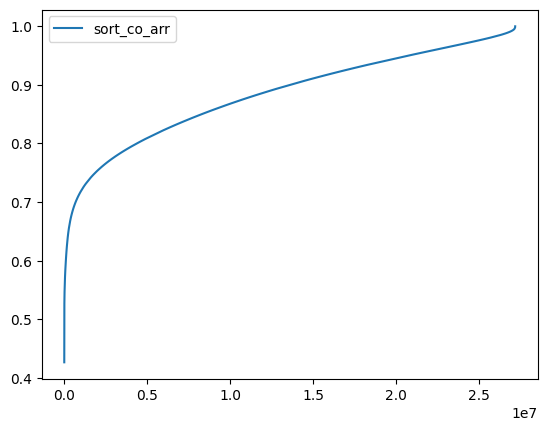

In [355]:
import matplotlib.pyplot as plt
plt.plot(np.sort(arr),label='sort_co_arr')
plt.legend()

In [244]:
df_lda_w2v_1 = pd.DataFrame(({'vec': [vec for vec in documents_vec]}, index=model.wd_data.index)
df_lda_w2v_1  = df_lda_w2v_1[df_lda_w2v_1['vec'].apply(np.sum) != 0]
df_lda_w2v_1['序号'] = wd_data.loc[df_lda_w2v_1.index,'序号']  # df_lda_w2v.merge(id_data[['序号']], left_index=True, right_index=True, how='left')
df_lda_w2v_1.set_index('序号', inplace=True)
df_lda_w2v_1.shape

(1197859, 1)

In [246]:
co_ids_vec = group_ids_1['序号'].apply(lambda x: df_lda_w2v_1.loc[df_lda_w2v_1.index.isin(x),'vec'].apply(pd.Series).mean(axis=0))

In [361]:
for i  in range(2000,2025):
    group_ids_t=patent_co_1[patent_co_1['申请年']<=i].groupby('Co')['序号'].apply(lambda x: x.to_list()).reset_index()
    co_ids_vec_t =group_ids_t['序号'].apply(lambda x: df_lda_w2v.loc[df_lda_w2v.index.isin(x)].mean(axis=0))
    co_ids_vec_t.index = group_ids_t['Co']
    co_ids_vec_t=co_ids_vec_t[co_ids_vec_t.sum(axis=1) != 0] 
    
    print(i,len(group_ids_t),len(co_ids_vec_t), cosine_sim_arr(co_ids_vec_t).mean())
    co_ids_vec_t.to_parquet(f'data\patent_co_vec_先进制造_{i}.parquet')

2000 20 20 0.8410943360013077
2001 36 36 0.8438048134920726
2002 52 51 0.8358112164424675
2003 68 67 0.8463742668463504
2004 87 85 0.8418154024884938
2005 108 105 0.8457371512802041
2006 156 152 0.8431780898746148
2007 228 223 0.8415669603593388
2008 335 327 0.8444184256888474
2009 453 450 0.8500302295190381
2010 614 612 0.8541669108859301
2011 820 818 0.8532844648311976
2012 1040 1038 0.8522086440276844
2013 1356 1354 0.8528266890283733
2014 1748 1746 0.8514832728890968
2015 2367 2366 0.8544592910140814
2016 3109 3108 0.8596518346675455
2017 3765 3765 0.8649895050464457
2018 4289 4289 0.8680361436169658
2019 4713 4713 0.8721550757551108
2020 5082 5082 0.8758058559739526
2021 6616 6616 0.874906331237934
2022 7048 7048 0.8782115078094669
2023 7362 7362 0.8794987219942204
2024 7370 7370 0.8795824828784314


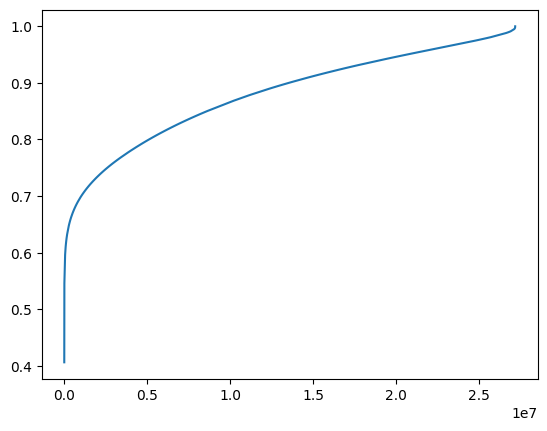

In [362]:
plt.plot(np.sort(cosine_sim_arr(co_ids_vec_t)))

In [273]:
model.document_topics[5]

[(10, 0.1518759),
 (12, 0.16684493),
 (18, 0.1926927),
 (37, 0.06638787),
 (41, 0.1779282),
 (45, 0.092338696)]

In [216]:
patent_co.iloc[5]

Co                                              珠海格力电器股份有限公司
序号                                                       166
标题 (中文)                                              电风扇摇头装置
摘要 (中文)    一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 ...
申请人                                             珠海格力电器股份有限公司
申请日                                               1994-08-31
申请号                                             CN94219340.7
公开（公告）号                                           CN2202815Y
table                                           patent202210
Name: 5, dtype: object

In [207]:
doc=patent_co.iloc[5]['标题 (中文)']+patent_co.iloc[5]['摘要 (中文)']
processed_doc=[w.strip().lower() for w in jieba.lcut(clean_doc(doc))
                             if not (len(w) < model.args.get('len_below', 2) or w.isdigit() 
                                     or re.match('\d+\.\d+$', w) or w in  model.stop_words)]

bow=model.dictionary.doc2bow(processed_doc)
topic_distribution=model.lda.get_document_topics(bow)

topic_n = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[: model.args.get('top_n_topics', None)]
distribute = np.array(topic_n)[:, 1]
mask = distribute >=  model.args.get('weight_threshold_topics', 0.0)  # 主题权重大于阈值

v_topics = np.array([topics_vec[t[0]] for t in topic_n])[mask]  # 主题向量

w_distribute = (distribute[mask] / np.sum(distribute[mask])).reshape(-1, 1)  # 将归一化结果作为每个技术主题的权重
v_doc = (w_distribute * v_topics).sum(axis=0) 
v_doc

array([ 0.2030736 ,  0.0922246 , -0.03551455,  0.10449886, -0.12880572,
        0.0290949 ,  0.1956326 ,  0.0983133 , -0.04207043, -0.06074722,
        0.15017703,  0.02804194, -0.12025003, -0.01374512,  0.21799757,
       -0.03157167, -0.04001462,  0.12498175,  0.24708626,  0.25752587,
       -0.04233388, -0.18551781,  0.18448228, -0.09561135, -0.04206844,
       -0.07635177, -0.02213457,  0.16615873, -0.11150866, -0.11551209,
       -0.00463161,  0.22030113, -0.3450857 ,  0.00718615,  0.04204296,
       -0.09287149, -0.33693223, -0.01812083, -0.01853391,  0.00887385,
       -0.04125123,  0.36315763, -0.18440225, -0.09419965,  0.11346693,
       -0.03405893,  0.1023463 ,  0.01687693,  0.15789835,  0.09382511,
        0.2168681 ,  0.11375513,  0.18099242, -0.03308989,  0.03784247,
        0.02288984, -0.02367583,  0.18434398, -0.01303859, -0.29882043,
        0.03553789, -0.3125755 ,  0.01978779,  0.13846349,  0.03150993,
        0.12231202,  0.10626524,  0.05516364,  0.1138864 ,  0.08

In [208]:
scores =cosine_similarity(documents_vec,v_doc.reshape(1, -1))
max_index = np.argmax(scores)
scores[max_index]

array([0.99999999])

In [ ]:
scores =cosine_similarity(documents_vec,v_doc.reshape(1, -1))
pd.Series(scores,index=self.sentences.index,name='score')

In [209]:
(df_lda_w2v.iloc[max_index]-documents_vec[max_index]).sum()

0.0

In [210]:
df_lda_w2v.iloc[max_index].name

166

In [211]:
patent_co.loc[patent_co.序号==166,'摘要 (中文)']

5    一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 ...
Name: 摘要 (中文), dtype: object

In [212]:
doc#相似主题

'电风扇摇头装置一种电风扇摇头装置，其特征在于由两个同轴安 装的上传动盘和下传动盘组成，上传动盘的下表面设 有凸起物，下传动盘的上表面设有供放置凸起物的径 向凹槽。该装置体积小，结构紧凑，为小型风扇的摇 头，特别是扇体的中心轴搭接在扇壳两端的这类电风 扇的变幅摇头摆动提供了可能性。'

In [265]:
patent_co

,Co,序号,标题 (中文),摘要 (中文),申请人,申请日,申请号,公开（公告）号,table
0,重庆钢铁股份有限公司,123,竖式烧结矿冷却机,本发明为一种具有环形风道和全密闭结构的竖式烧结矿冷却机，属冷却机技术领域；通过控制电振出料机...,重庆钢铁股份有限公司,1993-09-15,CN93117175.X,CN1050661C,patent202210
1,山东金泰集团股份有限公司,142,具有抗静电性的轻垢液体洗衣洗涤剂,本发明提供一种透明或半透明的具有抗静电性 的轻垢液体洗衣洗涤剂，包括(以重量计)5—20％合...,山东金泰集团股份有限公司,1994-04-14,CN94110539.3,CN1094440A,patent202210
2,山东鲁抗医药股份有限公司,154,麦白霉素胃溶片的生产工艺技术,一种麦白霉素胃溶片的生产工艺技术，以国产原 料组成新的配方，替代从国外进口的麦迪霉素胃溶 片...,山东鲁抗医药股份有限公司,1994-06-14,CN94110662.4,CN1104887A,patent202210
3,山东鲁抗医药股份有限公司,160,药品包装盒,省略其它视图。,山东鲁抗医药股份有限公司,1994-07-16,CN94307060.0,CN3033993D,patent202210
4,珠海格力电器股份有限公司,165,变幅摇头电风扇,一种变幅摇头电风扇，包括有扇座、扇体，其特征 在于扇体变幅摇头机构由电机驱动的一个T形连 杆...,珠海格力电器股份有限公司,1994-08-31,CN94219339.3,CN2201504Y,patent202210
...,...,...,...,...,...,...,...,...,...
1897512,深圳市大寰机器人科技有限公司,2781354,机器人标定方法、系统及机器人,本发明涉及机器人标定技术领域，具体而言，涉及一种机器人标定方法、系统及机器人，该方法包括：若...,深圳市大寰机器人科技有限公司,2024-03-01,CN202410231929.9,CN117798937A,patent202404
1897513,珠海光恒科技有限公司,2781355,一种多普勒激光测风雷达径向风速标定方法,本发明旨在提供一种满足高精度要求、目标校准不确定度低的多普勒激光测风雷达径向风速标定方法。本...,珠海光恒科技有限公司,2024-03-01,CN202410234087.2,CN117805792A,patent202404
1897514,珠海市申科谱工业科技有限公司,2781356,一种晶圆激光开槽装置及开槽方法,本发明旨在提供一种能实现双通道光路调节，能同时进行定位开槽和宽激光烧蚀的晶圆激光开槽装置。本...,珠海市申科谱工业科技有限公司,2024-03-01,CN202410233264.5,CN117798508A,patent202404
1897515,珠海市申科谱工业科技有限公司,2781357,一种微型塑料件激光焊接系统以及焊接方法,本发明提供一种微型塑料件激光焊接系统以及焊接方法，本发明通过塌陷值检测传感器对给予产品表面或...,珠海市申科谱工业科技有限公司,2024-03-01,CN202410233288.0,CN117799173A,patent202404


In [321]:
importlib.reload(w2v_lda)
from w2v_lda import *
tmp=W2vLda(sentences=None,wd_data=patent_co[:100],stop_words=Stopwords,suffix='111')

In [284]:
tmp.sentences

0     [竖式, 烧结, 冷却, 一种, 具有, 环形, 风道, 密闭, 结构, 竖式, 烧结, 冷...
1     [具有, 抗静电, 轻垢, 液体, 洗衣, 洗涤剂, 提供, 一种, 透明, 半透明, 具有...
2     [麦白, 霉素, 胃溶片, 生产工艺, 技术, 一种, 麦白, 霉素, 胃溶片, 生产工艺,...
4     [变幅, 摇头, 电风扇, 一种, 变幅, 摇头, 电风扇, 包括, 扇体, 特征, 扇体,...
5     [电风扇, 摇头, 装置, 一种, 电风扇, 摇头, 装置, 特征, 两个, 同轴, 传动,...
                            ...                        
92    [电池, 外观, 主创, 部分, 电池, 外包装, 图案, 色彩, 组合, 请求, 保护, 色彩]
93    [挂板, 五号, 视图, 视图, 相同, 省略, 视图, 仰视, 相同, 省略, 仰视, 请...
94    [挂板, 七号, 视图, 视图, 相同, 省略, 视图, 仰视, 相同, 省略, 仰视, 请...
98    [带电, 车削, 加工, 装置, 一种, 带电, 车削, 加工, 装置, 可控硅, 供电, ...
99    [影碟机, 包装盒, 相同, 故略, 视图, 仅为, 底色, 特殊, 设计, 要求, 故略,...
Name: 标题 (中文), Length: 68, dtype: object

In [285]:
tmp.group_ids

,Co,序号
0,云南铝业股份有限公司,"[1106, 1213]"
1,佛山电器照明股份有限公司,[174]
2,北京科技大学,[603]
3,南京熊猫电子股份有限公司,"[557, 898, 1053, 1274]"
4,唐山钢铁集团有限责任公司,"[389, 393, 404, 470, 471, 472, 504, 521, 538, ..."
5,四川长虹电器股份有限公司,"[330, 344]"
6,安阳钢铁股份有限公司,[603]
7,山东省药用玻璃股份有限公司,[271]
8,山东金泰集团股份有限公司,[142]
9,山东鲁抗医药股份有限公司,[154]


In [297]:
words=[]
for topic_id in range(model.lda.num_topics):
    word_distribute=model.lda.show_topic(topicid=topic_id, topn=30)
    words +=[(word,topic_id) for word, _ in word_distribute]
    
df_wt=pd.DataFrame(words,columns=['word','topic'])
df_wt

,word,topic
0,目标,0
1,测量,0
2,切换,0
3,沟槽,0
4,触发,0
...,...,...
1495,短路,49
1496,工作人员,49
1497,橡胶,49
1498,水流,49


In [307]:
df_wt.value_counts()[:32]

word
一种    36
包括    28
进行    22
用于    19
公开    17
提供    15
涉及    13
方法    12
提高    12
设置    10
装置     9
连接     8
实现     8
能够     8
具有     8
之间     7
应用     5
形成     5
表面     5
处理     5
一个     4
结构     4
位于     4
方向     4
执行     4
多个     4
效率     4
对应     4
至少     4
通信     4
确定     4
获取     4
Name: count, dtype: int64

In [353]:
df_wt=model.topics_words(topn=30)
df_wt.value_counts()[:20]

word
效率    7
接收    6
输入    5
情况    5
生成    5
过程    5
结构    5
位于    5
输出    4
性能    4
不同    4
配置    4
执行    4
计算    4
指令    4
实时    4
需求    3
类型    3
一侧    3
设有    3
Name: count, dtype: int64

In [299]:
'一种' in model.stop_words

False

In [300]:
'一种' in Stopwords

False

In [315]:
stop_1=[
'一种',
'每种',
'每次',
'根据',
'第一',
'第二',
'第三',
'所述',
'包括',
'进行',
'获取',
'对应',
'确定',
'基于',
'得到',
'提供',
'通过',
'方法',
'装置',
'请求',
'申请',
'一个',
'两个',
'多个',
"公开",
'应用',
"用于",
"使用",
"能够",
"实现",
"用以",
"上述",
"提高",
'采用',
'利用',
'获得',
'提升',
'之间',
'多笔',
'多种',
'是否',
'涉及',
'处理',
'形成',
'至少',
'具有']
stop_1+=df_wt.word.value_counts()[:16].index.tolist()

In [319]:
Stopwords=sorted(set(i.strip() for i in Stopwords+stop_1)) 
len(Stopwords)

6956

In [320]:
with open('data\\专利停用词表2024.txt', "w",encoding='UTF-8') as file:
    for item in Stopwords:
        file.write((item) + "\n")